# CPU vs GPU with GBM - 400 features + augmentation
---

The aim of this notebook is to compare two GBM models trained using CPU and with the [Kaggle's free GPU](https://www.kaggle.com/dansbecker/running-kaggle-kernels-with-a-gpu). 

I have already compared the [200 models (2 features each)](https://github.com/FedericoRaimondi/me/blob/master/Santander_Customer_Transaction_Prediction/PredictiveAnalysis_ModelTuning/PredictiveAnalysis_ModelTuning_GPU.ipynb) version and CPU performed better for LGBM because of the not large enough training datasets.

After [this discussion](https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/89004#521415) with [Chris Deotte](https://www.kaggle.com/cdeotte), I decided to compare also a 400 features + augmentation model to see if GPU wins against CPU.

**EDIT**: Chris correctly suggested to try also other kind of GBM (not only LGBM as I did in the previous version of the kernel) because, for instance with CatBoost the power of GPU is way more significative!

---
### _Let's start! :)_

First, in the notebook settings set **Internet connected**, and **GPU on**.

#### Enabling LGBM GPU
Then execute the 4 following cells. You can find the explanation in this [kernel](https://www.kaggle.com/vinhnguyen/gpu-acceleration-for-lightgbm/)![](http://)

In [1]:
!rm -r /opt/conda/lib/python3.6/site-packages/lightgbm
!git clone --recursive https://github.com/Microsoft/LightGBM
!apt-get install -y -qq libboost-all-dev

Cloning into 'LightGBM'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 13410 (delta 13), reused 10 (delta 3), pack-reused 13383
Receiving objects: 100% (13410/13410), 9.52 MiB | 0 bytes/s, done.
Resolving deltas: 100% (9558/9558), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'compute'
Cloning into '/kaggle/working/LightGBM/compute'...
remote: Enumerating objects: 33, done.        
remote: Counting objects: 100% (33/33), done.        
remote: Compressing objects: 100% (21/21), done.        
remote: Total 21689 (delta 12), reused 23 (delta 9), pack-reused 21656        
Receiving objects: 100% (21689/21689), 8.51 MiB | 0 bytes/s, done.
Resolving deltas: 100% (17532/17532), done.
Submodule path 'compute': checked out '36c89134d4013b2e5e45bc55656a18bd6141995a'
debconf: delaying package configuration, since apt-utils is not installed
(Re

In [2]:
%%bash
cd LightGBM
rm -r build
mkdir build
cd build
cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/ ..
make -j$(nproc)

-- The C compiler identification is GNU 6.3.0
-- The CXX compiler identification is GNU 6.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Try OpenMP C flag = [-fopenmp]
-- Performing Test OpenMP_FLAG_DETECTED
-- Performing Test OpenMP_FLAG_DETECTED - Success
-- Try OpenMP CXX flag = [-fopenmp]
-- Performing Test OpenMP_FLAG_DETECTED
-- Performing Test OpenMP_FLAG_DETECTED - Success
-- Found OpenMP: -fopenmp  
-- Looking for CL_VERSION_2_0
-- Looking for CL_VERSION_2_0 - not found
-- Looking for CL_VERSION_1_2
-- Looking for CL_VERSION_

rm: cannot remove 'build': No such file or directory


In [3]:
!cd LightGBM/python-package/;python3 setup.py install --precompile

running install
running build
running build_py
creating build
creating build/lib
creating build/lib/lightgbm
copying lightgbm/engine.py -> build/lib/lightgbm
copying lightgbm/plotting.py -> build/lib/lightgbm
copying lightgbm/compat.py -> build/lib/lightgbm
copying lightgbm/libpath.py -> build/lib/lightgbm
copying lightgbm/__init__.py -> build/lib/lightgbm
copying lightgbm/sklearn.py -> build/lib/lightgbm
copying lightgbm/basic.py -> build/lib/lightgbm
copying lightgbm/callback.py -> build/lib/lightgbm
running egg_info
creating lightgbm.egg-info
writing lightgbm.egg-info/PKG-INFO
writing dependency_links to lightgbm.egg-info/dependency_links.txt
writing requirements to lightgbm.egg-info/requires.txt
writing top-level names to lightgbm.egg-info/top_level.txt
writing manifest file 'lightgbm.egg-info/SOURCES.txt'
reading manifest file 'lightgbm.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
no previously-included directories found matching 'build'
writing manifest file 'lig

In [4]:
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
!rm -r LightGBM

**Great, we are ready to go!**

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import time
warnings.filterwarnings('ignore')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

# Any results you write to the current directory are saved as output.

# sklearn, LGBM and CatBoost
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import catboost as ctb

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

In [6]:
# Loading datasets
df_train = pd.read_csv('../input/santander-customer-transaction-prediction/train.csv')
df_test = pd.read_csv('../input/santander-customer-transaction-prediction/test.csv')

print("Train shape: " + str(df_train.shape))
print("Test shape: " + str(df_test.shape))

# Splitting the target variable and the features
X_train = df_train.loc[:,'var_0':]
y_train = df_train.loc[:,'target']

print(X_train.shape)
print(y_train.shape)

Train shape: (200000, 202)
Test shape: (200000, 201)
(200000, 200)
(200000,)


Sorting only *True Test data*... Yes, you already know the [kernel](https://www.kaggle.com/yag320/list-of-fake-samples-and-public-private-lb-split) ;)

One of the true winners: [YaG320](https://www.kaggle.com/yag320)!

In [7]:
synthetic_samples_indexes = pd.read_csv('../input/synthetic-samples-indexes/synthetic_samples_indexes.csv')

df_test_real = df_test.copy()
df_test_real = df_test_real[~df_test_real.index.isin(list(synthetic_samples_indexes['synthetic_samples_indexes']))]
X_test = df_test_real.loc[:,'var_0':]
X_test.shape

(100000, 200)

### Frequency Encoding
---

In [8]:
def get_count(df):
    '''
    Function that adds frequency columns for each variable (excluding 'ID_code', 'target').
    New columns names will be like 'var_X_count'.
    '''
    for var in [i for i in df.columns if i not in ['ID_code','target']]:
        df[var+'_count'] = df.groupby(var)[var].transform('count')
    return df

In [9]:
# Using both train and (real) test datasets to creates frequencies columns

X_tot = pd.concat([X_train, X_test])
print(X_tot.shape)

start = time.time()
X_tot = get_count(X_tot)
end = time.time()
print('Frequency encoding took %.2f seconds\nShape: ' %(end - start))
print(X_tot.shape)

X_train_count = X_tot.iloc[0:200000]
X_test_count = X_tot.iloc[200000:]

(300000, 200)
Frequency encoding took 95.01 seconds
Shape: 
(300000, 400)


In [10]:
# 0.8 train, 0.2 dev
X_train,X_valid,y_train,y_valid = train_test_split(X_train_count, y_train, test_size=0.2, random_state=42, stratify=y_train)

print('X_train shape: {}\n'.format(X_train.shape))
print('y_train shape: {}\n'.format(y_train.shape))
print('X_valid shape: {}\n'.format(X_valid.shape))
print('y_valid shape: {}'.format(y_valid.shape))

# List of all the features
features = [c for c in X_train.columns if c not in ['ID_code', 'target']]

X_train shape: (160000, 400)

y_train shape: (160000,)

X_valid shape: (40000, 400)

y_valid shape: (40000,)


### Augmentation
---

This data augmentation function is described [here](https://www.kaggle.com/jiweiliu/lgb-2-leaves-augment) by [Jiwei Liu](https://www.kaggle.com/jiweiliu).

I only modified the fact that the FE features are considered togheter with their own original features.

For instance: `var_0` and `var_0_count` are augmented togheter.

In [11]:
# Data Augmentation

def augment(x,y,t=2, model = 'lgbm'):
    '''
    Data Augmentation tx if y = 1 , (t/2)x if y = 0. Default t=6.
    Model could be 'lgbm' (Default) or 'catboost'
    '''
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(int(x1.shape[1]/2)):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
            x1[:,c+200] = x1[ids][:,c+200] # The new features must go with their original one!
        xs.append(x1)

    if model == 'lgbm':
        for i in range(t//2):
            mask = y==0
            x1 = x[mask].copy()
            ids = np.arange(x1.shape[0])
            for c in range(int(x1.shape[1]/2)):
                np.random.shuffle(ids)
                x1[:,c] = x1[ids][:,c]
                x1[:,c+200] = x1[ids][:,c+200] # The new features must go with their original one!
            xn.append(x1)
    elif model == 'catboost':
        for i in range(t//3):
            mask = y==0
            x1 = x[mask].copy()
            ids = np.arange(x1.shape[0])
            for c in range(int(x1.shape[1]/2)):
                np.random.shuffle(ids)
                x1[:,c] = x1[ids][:,c]
                x1[:,c+200] = x1[ids][:,c+200] # The new features must go with their original one!
            xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [12]:
start = time.time()
# Augmentation Only for training set!
X_tr_lgbm, y_tr_lgbm = augment(X_train.values, y_train.values, t=2, model = 'lgbm')
# X_tr_lgbm, y_tr_lgbm = augment(X_train.values, y_train.values, t=6, model = 'lgbm')
# With t=6 we can see a larger gap between gpu and cpu lgbm!

print('X_tr_lgbm Augmented shape: {}'.format(X_tr_lgbm.shape))
end = time.time()
print('t=2 Augmentation took %.2f seconds' %(end - start))

start2 = time.time()
X_tr_cat, y_tr_cat = augment(X_train.values, y_train.values, t=15, model = 'catboost')
print('X_tr_cat Augmented shape: {}'.format(X_tr_cat.shape))
end2 = time.time()
print('t=15 Augmentation took %.2f seconds' %(end2 - start2))

X_tr_lgbm = pd.DataFrame(data=X_tr_lgbm,columns=X_train.columns)
y_tr_lgbm = pd.DataFrame(data=y_tr_lgbm)
y_tr_lgbm.columns = ['target']

X_tr_cat = pd.DataFrame(data=X_tr_cat,columns=X_train.columns)
y_tr_cat = pd.DataFrame(data=y_tr_cat)
y_tr_cat.columns = ['target']

X_tr_lgbm Augmented shape: (336078, 400)
t=2 Augmentation took 210.06 seconds
X_tr_cat Augmented shape: (1120780, 400)
t=15 Augmentation took 1093.15 seconds


In [13]:
performance = {}

# LBGM Comparison
---

### 1st MODEL: LGBM with CPU

In [14]:
# CPU parameters

lgb_params = {
        'bagging_fraction': 0.77,
        'bagging_freq': 2,
        'lambda_l1': 0.7,
        'lambda_l2': 2,
        'learning_rate': 0.01,
        'max_depth': 3,
        'min_data_in_leaf': 22,
        'min_gain_to_split': 0.07,
        'min_sum_hessian_in_leaf': 19,
        'num_leaves': 20,
        'feature_fraction': 1,
        'save_binary': True,
        'seed': 42,
        'feature_fraction_seed': 42,
        'bagging_seed': 42,
        'drop_seed': 42,
        'data_random_seed': 42,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': 'false',
        'num_threads': 6
}

In [15]:
trn_data = lgb.Dataset(X_tr_lgbm, label=y_tr_lgbm) # Augmentation
val_data = lgb.Dataset(X_valid, label=y_valid)

start = time.time()
# Training
clf = lgb.train(lgb_params, trn_data, 100000, valid_sets = [val_data], verbose_eval=-1, early_stopping_rounds = 3000)
end = time.time()

lgb_cpu = end - start
print('>> CPU: It took %.2f seconds' %(lgb_cpu))

val_pred = clf.predict(X_valid[features], num_iteration=clf.best_iteration)
print(">> CV score: {:<8.5f}".format(roc_auc_score(y_valid, val_pred)))

performance['lgb_cpu'] = lgb_cpu

Training until validation scores don't improve for 3000 rounds.
Early stopping, best iteration is:
[21972]	valid_0's auc: 0.916821
>> CPU: It took 7477.89 seconds
>> CV score: 0.91682 


### 2nd MODEL: LGBM with GPU

In [16]:
# GPU parameters

lgb_params = {
        'bagging_fraction': 0.77,
        'bagging_freq': 2,
        'lambda_l1': 0.7,
        'lambda_l2': 2,
        'learning_rate': 0.01,
        'max_depth': 3,
        'min_data_in_leaf': 22,
        'min_gain_to_split': 0.07,
        'min_sum_hessian_in_leaf': 19,
        'num_leaves': 20,
        'feature_fraction': 1,
        'save_binary': True,
        'seed': 42,
        'feature_fraction_seed': 42,
        'bagging_seed': 42,
        'drop_seed': 42,
        'data_random_seed': 42,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': 'false',
        'num_threads': 6,
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0
}

In [17]:
trn_data = lgb.Dataset(X_tr_lgbm, label=y_tr_lgbm) # Augmentation
val_data = lgb.Dataset(X_valid, label=y_valid)

start = time.time()
# Training
clf = lgb.train(lgb_params, trn_data, 100000, valid_sets = [val_data], verbose_eval=-1, early_stopping_rounds = 3000)
end = time.time()

lgb_gpu = end - start
print('>> GPU: It took %.2f seconds' %(lgb_gpu))

val_pred = clf.predict(X_valid[features], num_iteration=clf.best_iteration)
print(">> CV score: {:<8.5f}".format(roc_auc_score(y_valid, val_pred)))

performance['lgb_gpu'] = lgb_gpu

Training until validation scores don't improve for 3000 rounds.
Early stopping, best iteration is:
[23172]	valid_0's auc: 0.916911
>> GPU: It took 4801.61 seconds
>> CV score: 0.91691 


# CatBoost
---

### MODEL: CatBoost with GPU

In [18]:
 cat_params = {
        'max_depth' : 7,
        'learning_rate' : 0.04,
        'colsample_bylevel' : 1.0,
        'objective' : "Logloss",
        'eval_metric' : 'AUC',
        'task_type' : "GPU",
        'random_seed': 42,
        'iterations': 100000,
        'use_best_model': True
 }

In [19]:
start = time.time()
clf = ctb.CatBoostClassifier(**cat_params)
clf.fit(X=X_tr_cat, y=y_tr_cat, eval_set=[(X_valid, y_valid)], verbose=5000, early_stopping_rounds = 3000)
end = time.time()

cat_gpu = end - start
print('>> GPU: It took %.2f seconds' %(cat_gpu))

val_pred = clf.predict_proba(X_valid)[:,1]
print(">> CV score: {:<8.5f}".format(roc_auc_score(y_valid, val_pred)))

performance['cat_gpu'] = cat_gpu

0:	learn: 0.6602789	test: 0.6581324	best: 0.6581324 (0)	total: 40.3ms	remaining: 1h 7m 7s
5000:	learn: 0.9437819	test: 0.9217612	best: 0.9217613 (4994)	total: 2m 47s	remaining: 52m 52s
10000:	learn: 0.9573895	test: 0.9221149	best: 0.9222907 (7978)	total: 5m 28s	remaining: 49m 19s
bestTest = 0.9222907424
bestIteration = 7978
Shrink model to first 7979 iterations.
>> GPU: It took 581.52 seconds
>> CV score: 0.92229 


# Results
---

In [20]:
def print_result(first_time, first_name, second_time, second_name, title):
    results = (first_time/60)-(second_time/60) # converting to minutes
    print('>> {} result:'.format(title))
    if results < 0:
        print(str(first_name)+' spent '+str(int(abs(results)))+' minutes less than '+str(second_name))
        print('It was %.2f times faster!'% (second_time/first_time))
    elif results > 0:
        print(str(second_name)+' spent '+str(int(abs(results)))+' minutes less than '+str(first_name))
        print('It was %.2f times faster!'% (first_time/second_time))
    else:
        print('CPU and GPU spent the exact same time: %.2f minutes'% first_time)

In [21]:
print_result(lgb_cpu,"LGBM CPU",lgb_gpu,"LGBM GPU", 'LGBM CPU vs GPU')
print_result(cat_gpu,"Cat GPU",lgb_cpu,"LGBM CPU",'CatBoost GPU vs LGBM CPU')
print_result(cat_gpu,"Cat GPU",lgb_gpu,"LGBM GPU",'CatBoost GPU vs LGBM GPU')

>> LGBM CPU vs GPU result:
LGBM GPU spent 44 minutes less than LGBM CPU
It was 1.56 times faster!
>> CatBoost GPU vs LGBM CPU result:
Cat GPU spent 114 minutes less than LGBM CPU
It was 12.86 times faster!
>> CatBoost GPU vs LGBM GPU result:
Cat GPU spent 70 minutes less than LGBM GPU
It was 8.26 times faster!


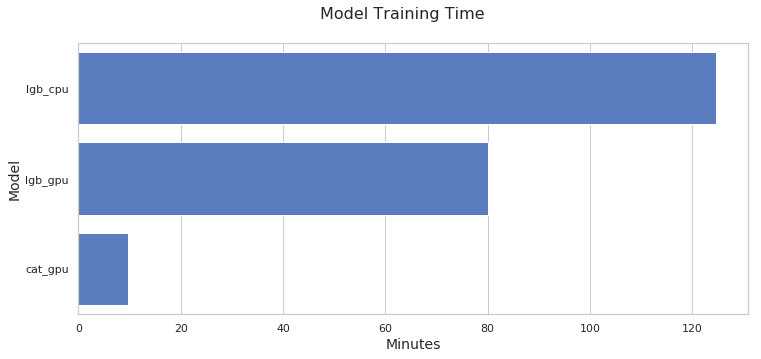

In [22]:
# Displaying results - Horizontal Barplot

performance_df = pd.DataFrame.from_dict(performance, orient='index')
performance_df.columns = ['time']
performance_df.reset_index(inplace=True)
performance_df['time'] = round(performance_df['time']/60, 2)

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 5))

# Plot the total crashes
sns.set_color_codes("muted")
sns.barplot(x="time", y='index', data=performance_df, color="b", tick_label=True)
f.suptitle('Model Training Time', fontsize=16)
ax.set_xlabel('Minutes', fontsize=14)
ax.set_ylabel('Model', fontsize=14)
plt.show()

### Additional comments

[](http://)
We can see the advantage of LGBM trained using GPU on a large enough dataset.

Anyway, we can observe the real GPU power looking at CatBoost (last model trained more than 1 mln rows much faster than others with less rows!!). Its performances are incredibly fast and even more accurate!

[Here](https://github.com/FedericoRaimondi/me/blob/master/Santander_Customer_Transaction_Prediction/PredictiveAnalysis_ModelTuning/PredictiveAnalysis_ModelTuning_GPU.ipynb) you can find the 200 models (2 feat each, LGBM) comparision and see how things change in that situation!

A SPECIAL THANKS to Chris Deotte for your tips and your contribution!

### Hope you liked this kernel... if you did, please upvote!